### beware when working with mcool files generated older version of `cooler zoomify` (circa <0.8.4) - those that had a split pixel issue https://github.com/open2c/cooler/issues/270

whenever this is the case - one should rezoomify the coolers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cooler
import bioframe

In [3]:
from cooltools.sandbox import obs_over_exp_cooler
import cooltools

In [4]:
from scipy.sparse import coo_matrix
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from time import perf_counter

In [6]:
# clr = cooler.Cooler("./ALV-repo/Hap1-WT-combined.mcool::/resolutions/500000")
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [24]:
# Load a Hi-C map at a 1Mb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/100000')

In [25]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
# create a view with chromosome arms using chromosome sizes and definition of centromeres
hg38_arms = bioframe.make_chromarms(hg38_chromsizes,  hg38_cens)
# select only those chromosomes available in cooler
hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)

# # when you've got no internet ...
# _chrom=["chr2","chr2","chr17","chr17"]
# _start=[0,93139351,0,24714921]
# _end=[93139351,242193529,24714921,83257441]
# _name=["chr2_p","chr2_q","chr17_p","chr17_q"]
# hg38_arms = pd.DataFrame({"chrom":_chrom,"start":_start,"end":_end,"name":_name})

hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2_p
1,chr2,93139351,242193529,chr2_q
2,chr17,0,24714921,chr17_p
3,chr17,24714921,83257441,chr17_q


In [26]:
# start = perf_counter()
# uuu=obs_over_exp_cooler.sum_pairwise(
#     clr,
#     view_df=hg38_arms,
#     transforms={"balanced" : lambda pix: pix["count"]*pix["weight1"]*pix["weight2"]},
#     clr_weight_name="weight",
#     ignore_diags=2,
#     chunksize=10_000_000,
# )
# uuu["exp"] = uuu["balanced.sum"]/uuu["n_valid"]
# # uuu = uuu.reset_index("dist")
# print(f"it took {perf_counter()-start} sec to complete ...")

In [27]:
uuu = obs_over_exp_cooler.expected_full_fast(
    clr,
    view_df=hg38_arms,
#     smooth_cis=False,
#     aggregate_smoothed=False,
#     smooth_sigma=0.1,
#     aggregate_trans=False,
#     expected_column_name="expected",
    ignore_diags=2,
    clr_weight_name='weight',
    chunksize=10_000_000,
    nproc=4,
)


In [28]:
uuu

,region1,region2,dist,balanced.sum,count.sum,n_valid,count.avg,balanced.avg
0,chr2_p,chr2_p,0,NaN,NaN,878.0,NaN,NaN
1,chr2_p,chr2_p,1,NaN,NaN,876.0,NaN,NaN
2,chr2_p,chr2_p,2,65.287351,2738583.0,874.0,3133.390160,0.074699
3,chr2_p,chr2_p,3,41.011675,1739972.0,872.0,1995.380734,0.047032
4,chr2_p,chr2_p,4,28.473626,1184707.0,870.0,1361.732184,0.032728
...,...,...,...,...,...,...,...,...
6511,chr17_q,chr17_q,581,0.000000,0.0,0.0,NaN,NaN
6512,chr17_q,chr17_q,582,0.000000,0.0,0.0,NaN,NaN
6513,chr17_q,chr17_q,583,0.000000,0.0,0.0,NaN,NaN
6514,chr17_q,chr17_q,584,0.000000,0.0,0.0,NaN,NaN


In [29]:
from cooltools.sandbox import expected_smoothing

In [30]:
# expected_smoothing.agg_smooth_cvd?

In [31]:
#     result_smooth = expected_smoothing.agg_smooth_cvd(
#         result,
#         sigma_log10=smooth_sigma,
#     )
#     # add smoothed columns to the result (only balanced for now)
#     result = result.merge(
#         result_smooth[["balanced.avg.smoothed", _DIST]],
#         on=[_REGION1, _REGION2, _DIST],
#         how="left",
#     )


In [32]:
uuu

,region1,region2,dist,balanced.sum,count.sum,n_valid,count.avg,balanced.avg
0,chr2_p,chr2_p,0,NaN,NaN,878.0,NaN,NaN
1,chr2_p,chr2_p,1,NaN,NaN,876.0,NaN,NaN
2,chr2_p,chr2_p,2,65.287351,2738583.0,874.0,3133.390160,0.074699
3,chr2_p,chr2_p,3,41.011675,1739972.0,872.0,1995.380734,0.047032
4,chr2_p,chr2_p,4,28.473626,1184707.0,870.0,1361.732184,0.032728
...,...,...,...,...,...,...,...,...
6511,chr17_q,chr17_q,581,0.000000,0.0,0.0,NaN,NaN
6512,chr17_q,chr17_q,582,0.000000,0.0,0.0,NaN,NaN
6513,chr17_q,chr17_q,583,0.000000,0.0,0.0,NaN,NaN
6514,chr17_q,chr17_q,584,0.000000,0.0,0.0,NaN,NaN


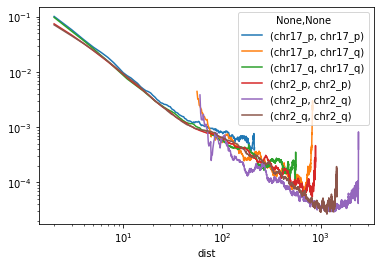

In [33]:
f,ax = plt.subplots()
for g,df in uuu[uuu["dist"]>0].groupby(["region1","region2"]):
    df.plot(x="dist",y="balanced.avg", loglog=True,ax=ax, label=g)
# # ax.set_ylim(0.5*1e-3,1)

In [23]:
# f,ax = plt.subplots()
# uuu.loc[(0,0),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="00")
# uuu.loc[(0,1),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="01")
# uuu.loc[(1,1),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="11")
# uuu.loc[(2,2),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="22")
# uuu.loc[(2,3),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="23")
# uuu.loc[(3,3),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="33")

# # ax.set_ylim(0.5*1e-3,1)

In [23]:
# calculate full expected (cis + trans)
expected_df = obs_over_exp_cooler.expected_full(
    clr,
    view_df=hg38_arms,
    smooth_cis=False,
    aggregate_trans=True,
    expected_column_name="expected",
    nproc=4,
)

INFO:root:Done calculating cis expected in 50.654 sec ...
INFO:root:Done calculating trans expected in 26.196 sec ...
INFO:root:Returning combined expected DataFrame.


In [52]:
hui.reset_index(level=["r1","r2"],drop=True).reset_index(level="dist")

,dist,count.sum,balanced.sum
0,0,32061001,22391.162801
1,1,29927412,22066.898493
2,2,8706228,6529.232708
3,3,3804582,2843.349631
4,4,2136953,1592.015747
...,...,...,...
295212,242040,1,0.002267
295213,242053,1,0.003446
295214,242067,1,0.001928
295215,0,104736,81.802771


In [47]:
hg38_arms.loc[hui.index.get_level_values("r2"), "name"].to_numpy()

array(['chr2_p', 'chr2_p', 'chr2_p', ..., 'chr2_q', 'chr17_p', 'chr17_q'],
      dtype=object)

In [ ]:
zzz=expected_df.set_index(["r1","r2"]).rename(columns={"balanced.avg":"exp"})
f,ax = plt.subplots()
zzz.loc[(0,0),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="00")
zzz.loc[(0,1),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="01")
zzz.loc[(1,1),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="11")
zzz.loc[(2,2),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="22")
zzz.loc[(2,3),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="23")
zzz.loc[(3,3),["dist","exp"]].plot(x="dist",y="exp", loglog=True,ax=ax, label="33")
ax.set_ylim(0.5*1e-3,1e-1)

In [ ]:
# collect obs/exp for chunks of pixel table (in memory for 1Mb cooler)
results = []
for oe_chunk in obs_over_exp_cooler.obs_over_exp_generator(
        clr,
        expected_df,
        view_df=hg38_arms,
        expected_column_name="expected",
        oe_column_name='oe',
        chunksize=1_000_000,
    ):
    results.append(oe_chunk)
# concat chunks into single DataFrame - res_df - is a new pixel table - sparse matrix
res_df = pd.concat(results, ignore_index=True)
res_df.head()

In [ ]:
# res_df: sparse matrix -> dense matrix for plotting
N = len(clr.bins())
oe = coo_matrix(
    (res_df["oe"], (res_df["bin1_id"], res_df["bin2_id"])),
    shape=(N,N),
).toarray()
# make it symmetric ...
oe = oe + oe.T
print(f"generated symmetrix obs/exp matrix of size {N} X {N}")

In [ ]:
# plot observed and stitched obs/exp side by side
istart, iend = 0, 327
obs = clr.matrix()[istart:iend, istart:iend]
obs_exp = oe[istart:iend, istart:iend]

f,axs = plt.subplots(1,2,figsize=(14,10))
img = axs[0].imshow(
    obs,
    interpolation="none",
    cmap="YlOrRd",
    norm=colors.LogNorm(vmin=0.00005,vmax=0.01)
)
plt.colorbar(img,ax=axs[0],orientation="horizontal")
img = axs[1].imshow(
    obs_exp,
    interpolation="none",
    cmap="coolwarm",
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
)
plt.colorbar(img,ax=axs[1],orientation="horizontal")

### Try higher resolution data and write directly into cooler 

In [ ]:
# try 10kb ...
clr = cooler.Cooler('./test.mcool::/resolutions/10000')

In [ ]:
# generate bins table with weights=1, and NaN for bad bins ...
bins_oe = clr.bins()[:]
_bad_mask = bins_oe["weight"].isna()
bins_oe["weight"] = 1.
bins_oe.loc[_bad_mask,"weight"] = np.nan

In [ ]:
# re-calculate full expected (cis + trans) at higher resolution
expected_df = obs_over_exp_cooler.expected_full(
    clr,
    view_df=hg38_arms,
    smooth_cis=False,
    aggregate_trans=True,
    expected_column_name="expected",
    nproc=4,
)

In [ ]:
# setup a generator (lazy) of obs/exp pixels
oe_pixels_stream = obs_over_exp_cooler.obs_over_exp_generator(
    clr,
    expected_df,
    view_df=hg38_arms,
    expected_column_name="expected",
    oe_column_name='oe',
    chunksize=10_000_000
)

In [ ]:
# write oe_pixels_stream into cooler - with custom column "oe" (can do "count":float for higlass)
cooler.create_cooler(
    cool_uri = "fun.cool",
    bins = bins_oe,
    pixels = oe_pixels_stream,
    columns=["oe"],
    dtypes={"oe":np.float64},
)

In [ ]:
# plot observed and stitched obs/exp side by side directly from the new cooler
istart, iend = 23_000, 25_000
obs = clr.matrix()[istart:iend, istart:iend]
obs_exp = cooler.Cooler("fun.cool").matrix(field="oe")[istart:iend, istart:iend]

f,axs = plt.subplots(1,2,figsize=(14,10))
img = axs[0].imshow(
    obs,
    interpolation="none",
    cmap="YlOrRd",
    norm=colors.LogNorm(vmin=0.00005,vmax=0.01)
)
plt.colorbar(img,ax=axs[0],orientation="horizontal")

# make sure zeros are displayed as "lowest" obs/exp according to the colormap
cm = plt.cm.get_cmap("coolwarm")
cm.set_under(cm(0))

img = axs[1].imshow(
    obs_exp+10**-8,
    interpolation="none",
    cmap=cm,
    norm=colors.LogNorm(vmin=0.4,vmax=2.5)
    # add color to the "under" - to avoid adding "floor" to obs_exp
    # 
)
plt.colorbar(img,ax=axs[1],orientation="horizontal")